In [1]:
import sys
sys.path.append('/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import multiprocessing

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error

%load_ext autoreload
%autoreload 2

In [2]:
graph1 = load_dicty()
graph2 = load_pharma()

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Experimental condition	282
0	
1	expr-(1219, 282)
Gene	1219
3	ann-(1219, 116), expr-(1219, 282), ppi-(1219, 1219)
0	
GO term	116
0	
1	ann-(1219, 116)

0.0
1.0

0.0
1.0

0.0
1.0

0.0
1.0

0.0
1.0

0.0
1.0

-------------RelationGraph-------------
Depositor	189
1	depo_cats-(189, 16)
1	depositors-(1260, 189)
Action	130
0	
1	actions-(1260, 130)
Chemical	1260
5	actions-(1260, 130), pudmed-(1260, 7948), depositors-(1260, 189), fingerprints-(1260, 920), tanimoto-(1260, 1260)
0	
Depositor category	16
0	
1	depo_cats-(189, 16)
Fingerprint	920
0	
1	fingerprints-(1260, 920)
PMID	7948
0	
1	pudmed-(1260, 7948)



In [5]:
def data_generator(filenames, n_pack):
    # n_pack => 100 samples of matrix
    # n_pack = batch_size
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        for i in range(len(files)):
            rand_num = np.random.randint(len(num_packs[i]))
            f = files[i]
            pack = num_packs[i]
            x.append(f[pack[rand_num]])
            
        yield (x, x)
        
        if counter >= n_pack:
            counter = 0
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
#         tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
#         tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
#         np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data
            
    
class MultiModal:
    
    def __init__(self, graph=None, path=''):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        self._input_layer(relation.matrix.shape)
        
        row, col = relation.matrix.shape
        self.org_data.append(np.array(relation.matrix).reshape(1,row,col,1))
        self.input_data_size.append(relation.matrix.shape)
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
        
#         Conv2D filtered by columns
        layer1 = Conv2D(64, (1, col-7), activation='relu', padding='valid')(visible)
        layer1 = MaxPooling2D((2, 2))(layer1)
        layer1 = Conv2D(32, (3, 3), activation='relu')(layer1)
        layer1 = MaxPooling2D((2, 2))(layer1)
        layer1 = Conv2D(1, (1, 1), activation='relu')(layer1)
        layer1 = Flatten()(layer1)
        
        self.input_layers.append(layer1)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size

        layer = Dense(row, activation='relu')(self.inputs)
        layer = Reshape((row, 1, 1))(layer)
        layer = UpSampling2D((1, col))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _encoder(self):
        x = Dense(1000, activation="relu")(self.inputs)
        x = Dense(100, activation="relu")(x)
        x = Dense(20, activation="relu")(x) 
        self.inputs = x
        
    def _decoder(self):
        x = Dense(100, activation="relu")(self.inputs)
        x = Dense(1000, activation="relu")(x)
        self.inputs = x
        
    def _callbacks(self):
        log_dir = '/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True),
            EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
        ]
        
    def build_model(self, optimizer='sgd', loss='mse'):
        self.inputs = concatenate(self.input_layers)
        self._encoder()
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        self.model.compile(optimizer=optimizer, loss=loss)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, batch_size), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + ' - ' + str(predict_mean) + '\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
       

In [90]:
model = MultiModal(graph=graph1, path='/data/samples/multiple_inputs/dicty/')
model.build_model(optimizer='adadelta', loss='binary_crossentropy')
model.fit(500, 30)
model.save('/data/multimodal/dicty/', '1')
model.predict()

ann	(1219, 116)
expr	(1219, 282)
ppi	(1219, 1219)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           (None, 1219, 116, 1) 0                                            
__________________________________________________________________________________________________
input_66 (InputLayer)           (None, 1219, 282, 1) 0                                            
__________________________________________________________________________________________________
input_67 (InputLayer)           (None, 1219, 1219, 1 0                                            
__________________________________________________________________________________________________
conv2d_183 (Conv2D)             (None, 1219, 1, 1)   117         input_65[0][0]                   
___________________________________________________________

In [6]:
model1 = MultiModal(graph=graph1, path='/data/samples/multiple_inputs/dicty/')
model1.load_model('/data/multimodal/dicty/', '1')
model1.predict(random=True)

expr	(1219, 282)
ann	(1219, 116)
ppi	(1219, 1219)
Data		Density		Predict		BaseLine	AVG Mean		Predict (min)	Predict (max)	
(1219,116) 	5.34% 		5.0572% 	1.71738% 	0.05341 - 0.00225	0.00014		0.24343	
(1219,282) 	95.19% 		7.89924% 	9.39611% 	0.82182 - 0.56116	0.0		0.59893	
(1219,1219) 	3.09% 		2.08738% 	1.00321% 	0.0248 - 0.00068	0.0		0.04031	


(1219, 116)


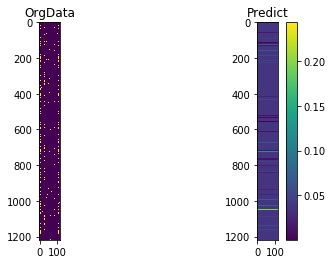

<Figure size 432x288 with 0 Axes>

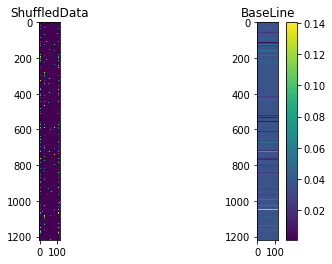

<Figure size 432x288 with 0 Axes>

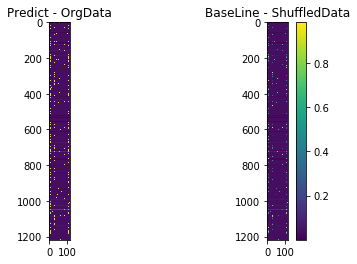

(1219, 282)


<Figure size 432x288 with 0 Axes>

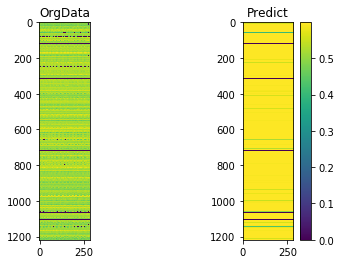

<Figure size 432x288 with 0 Axes>

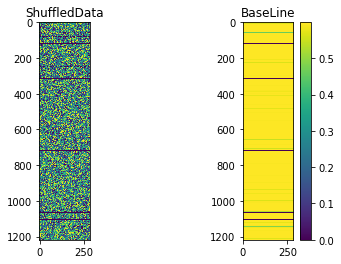

<Figure size 432x288 with 0 Axes>

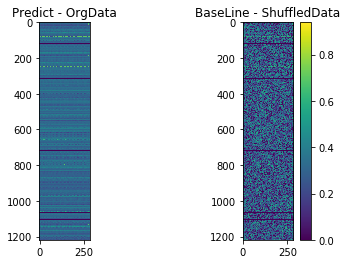

(1219, 1219)


<Figure size 432x288 with 0 Axes>

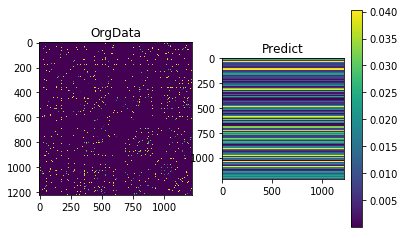

<Figure size 432x288 with 0 Axes>

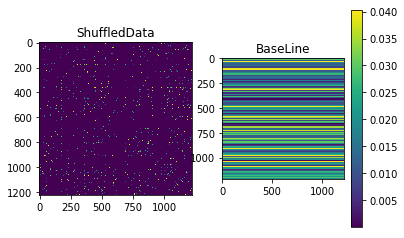

<Figure size 432x288 with 0 Axes>

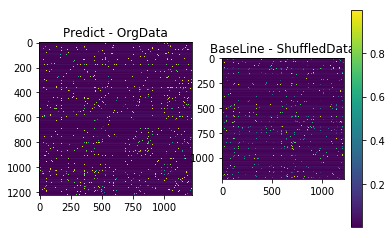

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
numOfExperiment = 1
path = '/mag/Experiments/Results/'+ str(numOfExperiment) + '/dicty/'

for i in range(len(model1.org_data)):
    _, row, col, _ = model1.org_data[i].shape
    org_data = model1.org_data[i].reshape(row, col)
    shuffled_data = model1.shuffled_data[i].reshape(row, col)
    predict = model1.predict_data[i].reshape(row, col)
    base_line = model1.base_line[i].reshape(row, col)
    print(org_data.shape)


    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('OrgData')
    plt.imshow(org_data)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('Predict')
    plt.imshow(predict)
    plt.colorbar()
    plt.show()
    plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('ShuffledData')
    plt.imshow(shuffled_data)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('BaseLine')
    plt.imshow(base_line)
    plt.colorbar()
    plt.show()
    plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + '_randomData_vs_predictBaseLine.png')

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('Predict - OrgData')
    plt.imshow(np.abs(predict - org_data))
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('BaseLine - ShuffledData')
    plt.imshow(np.abs(base_line - shuffled_data))
    plt.colorbar()
    plt.show()
    plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + '_intersection.png')

In [ ]:
model = MultiModal(graph=graph2, path='/data/samples/multiple_inputs/pharma/')
model.build_model(optimizer='adadelta', loss='binary_crossentropy')
model.fit(500, 30)
model.save('/data/multimodal/pharma/', '1')
model.predict()

depo_cats	(189, 16)
depositors	(1260, 189)
pudmed	(1260, 7948)
actions	(1260, 130)
fingerprints	(1260, 920)
tanimoto	(1260, 1260)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_86 (InputLayer)           (None, 189, 16, 1)   0                                            
__________________________________________________________________________________________________
input_87 (InputLayer)           (None, 1260, 189, 1) 0                                            
__________________________________________________________________________________________________
input_88 (InputLayer)           (None, 1260, 7948, 1 0                                            
__________________________________________________________________________________________________
input_89 (InputLayer)           (None, 1260, 130, 1) 0                        

Epoch 1/30
500/500 [==============================] - 435s 869ms/step - loss: 2.3543 - conv2d_270_loss: 0.2416 - conv2d_271_loss: 0.4567 - conv2d_272_loss: 0.0675 - conv2d_273_loss: 0.5375 - conv2d_274_loss: 0.3591 - conv2d_275_loss: 0.6918
Epoch 2/30
500/500 [==============================] - 414s 828ms/step - loss: 1.9941 - conv2d_270_loss: 0.1959 - conv2d_271_loss: 0.4275 - conv2d_272_loss: 0.0389 - conv2d_273_loss: 0.3121 - conv2d_274_loss: 0.3292 - conv2d_275_loss: 0.6906
Epoch 3/30
159/500 [========>.....................] - ETA: 4:29 - loss: 1.8738 - conv2d_270_loss: 0.1858 - conv2d_271_loss: 0.4208 - conv2d_272_loss: 0.0302 - conv2d_273_loss: 0.2254 - conv2d_274_loss: 0.3211 - conv2d_275_loss: 0.6905

In [14]:
model1 = MultiModal(graph=graph2, path='/data/samples/multiple_inputs/pharma/')
model1.load_model('/data/multimodal/pharma/', '1')
model1.predict(random=True)

depo_cats	(189, 16)
depositors	(1260, 189)
actions	(1260, 130)
pudmed	(1260, 7948)
fingerprints	(1260, 920)
tanimoto	(1260, 1260)
Data		Density		Predict		BaseLine	AVG Mean		Predict (min)	Predict (max)	
(189,16) 	6.18% 		5.66323% 	2.06671% 	0.06184 - 0.00422	0.0		0.90981	
(1260,189) 	21.37% 		16.96561% 	6.13474% 	0.2137 - 0.03308	0.0		0.19403	
(1260,7948) 	0.38% 		0.36926% 	0.12464% 	0.00375 - 5e-05	0.0		0.03466	
(1260,130) 	4.04% 		3.88476% 	1.28292% 	0.04042 - 0.00121	0.00058		0.09672	
(1260,920) 	13.54% 		11.78394% 	4.11425% 	0.13537 - 0.01334	0.0		0.1122	
(1260,1260) 	99.25% 		6.56235% 	8.60938% 	0.66718 - 0.46589	0.00069		0.90017	


(189, 16)


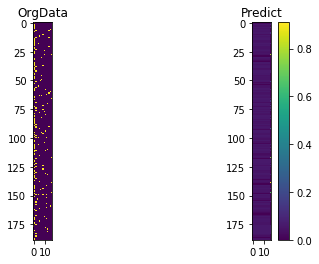

<Figure size 432x288 with 0 Axes>

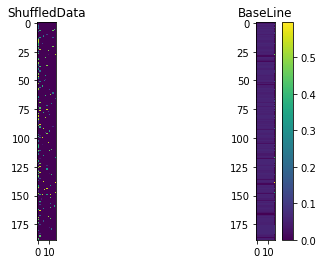

<Figure size 432x288 with 0 Axes>

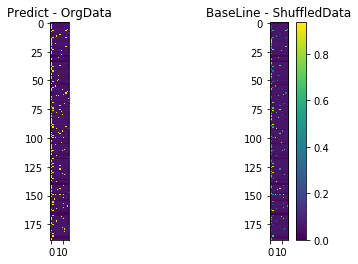

(1260, 189)


<Figure size 432x288 with 0 Axes>

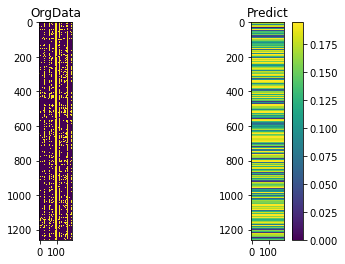

<Figure size 432x288 with 0 Axes>

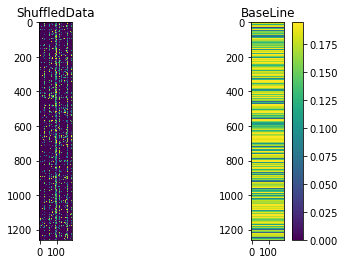

<Figure size 432x288 with 0 Axes>

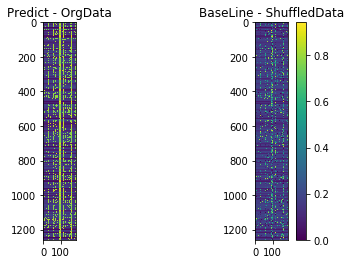

(1260, 7948)


<Figure size 432x288 with 0 Axes>

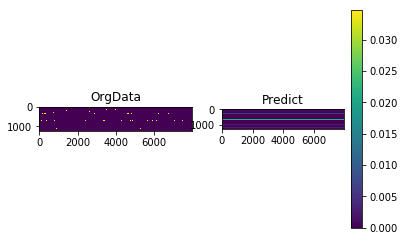

<Figure size 432x288 with 0 Axes>

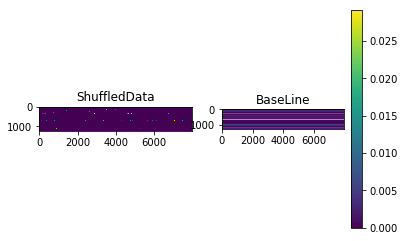

<Figure size 432x288 with 0 Axes>

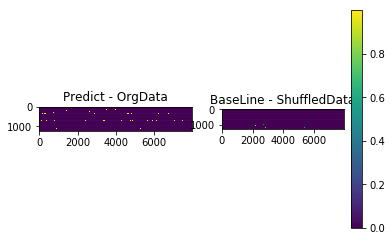

(1260, 130)


<Figure size 432x288 with 0 Axes>

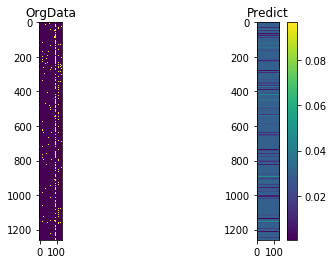

<Figure size 432x288 with 0 Axes>

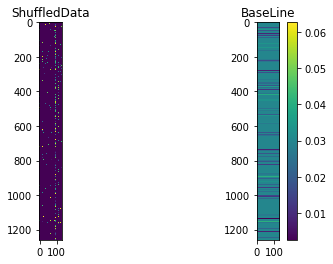

<Figure size 432x288 with 0 Axes>

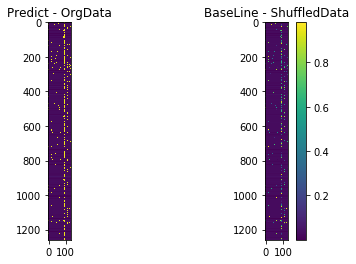

(1260, 920)


<Figure size 432x288 with 0 Axes>

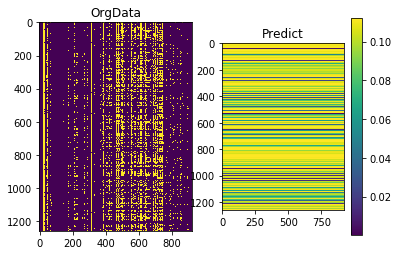

<Figure size 432x288 with 0 Axes>

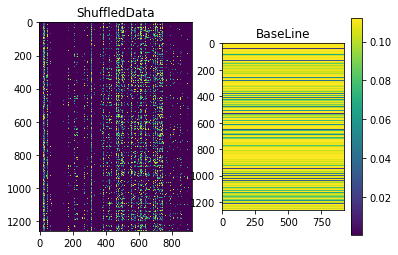

<Figure size 432x288 with 0 Axes>

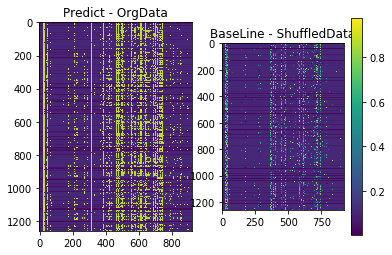

(1260, 1260)


<Figure size 432x288 with 0 Axes>

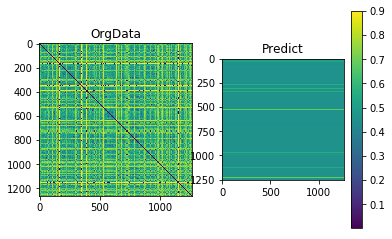

<Figure size 432x288 with 0 Axes>

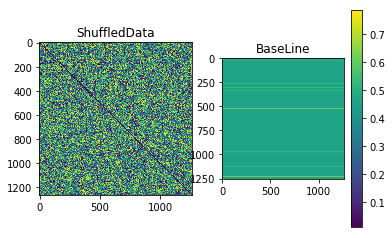

<Figure size 432x288 with 0 Axes>

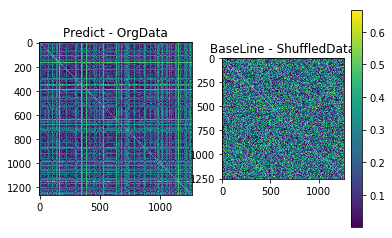

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
numOfExperiment = 1
path = '/mag/Experiments/Results/'+ str(numOfExperiment) + '/pharma/'

for i in range(len(model1.org_data)):
    _, row, col, _ = model1.org_data[i].shape
    org_data = model1.org_data[i].reshape(row, col)
    shuffled_data = model1.shuffled_data[i].reshape(row, col)
    predict = model1.predict_data[i].reshape(row, col)
    base_line = model1.base_line[i].reshape(row, col)
    print(org_data.shape)


    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('OrgData')
    plt.imshow(org_data)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('Predict')
    plt.imshow(predict)
    plt.colorbar()
    plt.show()
    plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('ShuffledData')
    plt.imshow(shuffled_data)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('BaseLine')
    plt.imshow(base_line)
    plt.colorbar()
    plt.show()
    plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + '_randomData_vs_predictBaseLine.png')

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.title.set_text('Predict - OrgData')
    plt.imshow(np.abs(predict - org_data))
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.title.set_text('BaseLine - ShuffledData')
    plt.imshow(np.abs(base_line - shuffled_data))
    plt.colorbar()
    plt.show()
    plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_' + str(i) + '_intersection.png')